In [715]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd

import math
from sklearn import metrics
from random import randint

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

import re
import env

plt.style.use('tableau-colorblind10')
plt.rcParams['figure.figsize'] = (13, 5)

# Anomaly Detection Project

Due Friday@2pm
* Write email
* 1-slide summary

Data: "curriculum_logs database" (real data, all students, don't publish ips or locations)

Note: C19 starts in data

You recieved this email:

    I have some questions for you that I need to be answered before the board meeting Friday afternoon. I need to be able to speak to the following questions. I also need a single slide that I can incorporate into my existing presentation (Google Slides) that summarizes the most important points. My questions are listed below; however, if you discover anything else important that I didn’t think to ask, please include that as well.

    1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
    2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
    3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
    4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
    5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
    6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
    7. Which lessons are least accessed?
    8. Anything else I should be aware of?


* To turn in your project, email datascience@codeup.com with the subject line "Anomaly Detection Project"
• To get 100 on this project you only need to answer 5 out of the 7 questions (along with the other deliverables listed below i.e. slide, your notebook, etc).
• Submit a link to a final notebook on GitHub that asks and answers questions - document the work you do to justify findings
• Compose an email with the answers to the questions/your findings, and in the email, include the link to your notebook in GitHub and attach your slide.
• You will not present this, so be sure that the details you need your leader to convey/understand are clearly communicated in the email.
• Your slide should be like an executive summary and be in form to present.
• Continue to use best practices of acquire.py, prepare.py, etc.
• Since there is no modeling to be done for this project, there is no need to split the data into train/validate/test
• The cohort schedule is in the SQL database, and alumni.codeup.com has info as well.


In [2]:
dbname = "curriculum_logs" #logs start Jan. 2018
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{dbname}'
df_orig = pd.read_sql('''SELECT * FROM logs
                         JOIN cohorts on cohorts.id = logs.cohort_id
                         ''', url)

In [3]:
#pd.read_sql("SHOW TABLES", url)

In [896]:
#prepare
df = df_orig.copy()
df['datetime'] =  pd.to_datetime(df.date +" "+ df.time)
df = df.set_index(df.datetime)

df=df[df.program_id!=4] #only five, who cares
df.program_id = df.program_id.map({1:'PHP', 2:'Java', 3:'Data'}) #map number to program
df.name = df.name + "-" + df.program_id #concatenate cohort and program
print(df.program_id.value_counts())
df = df.drop(columns=['id','cohort_id','deleted_at','slack','created_at',
                      'updated_at','date','time','datetime','program_id'])
df.sample()

Java    713365
Data    103412
PHP      30548
Name: program_id, dtype: int64


,path,user_id,ip,name,start_date,end_date
datetime,,,,,,
2021-01-28 14:50:53,javascript-i/introduction/working-with-data-ty...,876,98.6.122.83,Marco-Java,2021-01-25,2021-07-19


In [897]:
paths = df.path.str.split("/") #split subdirectories
home = []
#to match 3-classifiation, e.g.
r = re.compile(r'\d*-')

#make list of top subdirectory
for s in paths:
    try:
        s=s[0]
        #some lessons have numbers
        if r.match(s):
            home.append(s.split("-", maxsplit=1)[1])
        else:
            home.append(s)
    except:
        home.append(None)
        
df['path'] = home #make path only the top subdirectory

In [898]:
#standardizing path names
df.path[df.path==""]="empty"
df.path[df.path == '3.0-mysql-overview'] = 'mysql'
df.path[df.path == '1._Fundamentals'] = 'fundamentals'
df.path[df.path == 'capstone'] = 'capstones'
df.path[df.path == 'javascript'] = 'javascript-i'
df.path[df.path == 'working-with-time-series-data'] = 'timeseries'

In [899]:
#dataframe without codeup ips
df = df[df.ip.str[:-3] != "97.105.19"]

#make column showing count of that path for that cohort
df['cohort_path_counts'] = df.groupby(['path','name'])['path'].transform('count')

In [900]:
df.to_csv("project/prepared.csv")
df.sample()

,path,user_id,ip,name,start_date,end_date,cohort_path_counts
datetime,,,,,,,
2021-01-07 14:17:23,html-css,803,76.183.213.133,Kalypso-Java,2020-11-02,2021-05-04,2935.0


In [901]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 518125 entries, 2018-01-26 10:59:02 to 2021-04-21 16:44:39
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   path                518124 non-null  object 
 1   user_id             518125 non-null  int64  
 2   ip                  518125 non-null  object 
 3   name                518125 non-null  object 
 4   start_date          518125 non-null  object 
 5   end_date            518125 non-null  object 
 6   cohort_path_counts  518124 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 31.6+ MB


### Unusual activity

In [730]:
pings_by_ip = df.groupby('ip').count()['path'].sort_values(ascending=False)
stdev = 3 #more than 3 std above mean
anomaly_ips = pings_by_ip[pings_by_ip > pings_by_ip.mean() + stdev*pings_by_ip.std()]
anomaly_ips

ip
192.171.117.210    9124
71.150.217.33      6791
76.185.145.231     4754
12.106.208.194     4343
67.11.50.23        4181
                   ... 
68.201.233.142     1201
66.69.108.117      1199
76.183.231.195     1185
72.181.108.107     1171
67.11.85.236       1168
Name: path, Length: 103, dtype: int64

In [733]:
pings_per_time = df.ip.resample('20Min').count().sort_values(ascending=False)
#more than 3 std above mean
print(f'there are {len(pings_per_time)} windows')
anomaly_pings = pings_per_time[pings_per_time > pings_per_time.mean() + stdev*pings_per_time.std()]
anomaly_pings

there are 85051 windows


datetime
2020-06-02 09:00:00    375
2021-03-19 09:20:00    345
2021-03-19 09:00:00    323
2021-03-19 09:40:00    321
2020-07-16 09:40:00    306
                      ... 
2020-07-24 14:40:00     52
2021-03-15 14:40:00     52
2020-05-27 11:00:00     52
2020-09-24 15:00:00     52
2020-07-02 15:20:00     52
Name: ip, Length: 1928, dtype: int64

In [736]:
idx = 0
new_time = str(anomaly_pings.index[idx])[:-5] + str(int(str(anomaly_pings.index[idx])[-5:-3])+10) + ":00"
df[(df.index < new_time) & (df.index > anomaly_pings.index[idx])].sample(6)

,path,user_id,ip,name,start_date,end_date
datetime,,,,,,
2020-06-02 09:07:08,mysql,596,75.20.162.161,Apex-Java,2020-02-24,2020-07-29
2020-06-02 09:00:23,mysql,608,76.218.3.43,Apex-Java,2020-02-24,2020-07-29
2020-06-02 09:02:34,mysql,608,76.218.3.43,Apex-Java,2020-02-24,2020-07-29
2020-06-02 09:05:55,java-iii,64,71.150.217.33,Staff-Java,2014-02-04,2014-02-04
2020-06-02 09:03:17,mysql,605,72.190.25.232,Apex-Java,2020-02-24,2020-07-29
2020-06-02 09:01:30,mysql,605,72.190.25.232,Apex-Java,2020-02-24,2020-07-29


In [745]:
pages = df['path'].resample('d').count()

In [746]:
#EMA
ema_7d = pages.ewm(span=7).mean()
ema_14d = pages.ewm(span=14).mean()
ema_30d = pages.ewm(span=30).mean()
ema_90d = pages.ewm(span=90).mean()

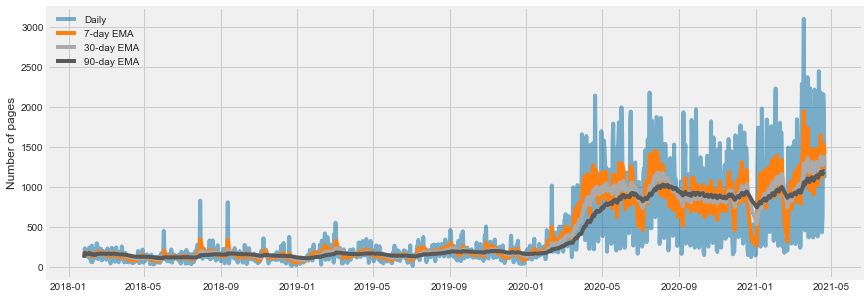

In [747]:
fig, ax = plt.subplots()

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
#ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [748]:
#Bollinger bands

# set the window span
span = 30
weight = 2

# compute midband
midband = pages.ewm(span=span).mean()
# compute exponential stdev
stdev = pages.ewm(span=span).std()
# compute upper and lower bands
ub = midband + stdev*weight
lb = midband - stdev*weight

# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)
bb.columns = ['ub', 'lb']
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']

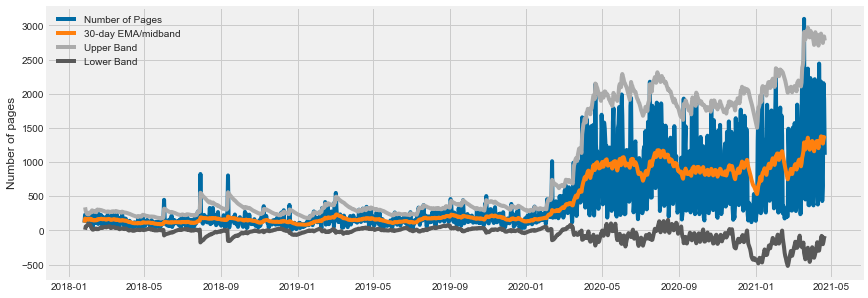

In [749]:
fig, ax = plt.subplots()

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [750]:
#Compute %b

# get the last measure of gb
last_measure = my_df.iloc[-1].pages
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

In [751]:
print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.42


In [752]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

In [753]:
thresh = 1.
#adjust span, weight, and thresh to change anomaly results
my_df[my_df.pct_b>thresh].sort_values(by="pct_b", ascending=False)

,pages,midband,ub,lb,pct_b
datetime,,,,,
2018-07-30,826,187.877045,551.481649,-175.727559,1.377496
2018-09-12,805,203.801934,559.052239,-151.448371,1.346161
2018-06-02,448,122.296331,317.956380,-73.363719,1.332320
2020-02-11,1013,298.478675,740.517497,-143.560147,1.308211
2020-02-03,456,197.615360,384.037690,11.193029,1.193009
2018-12-19,373,135.607536,306.980307,-35.765236,1.192620
2019-09-02,459,218.044710,398.442089,37.647330,1.167846
2020-03-16,991,406.752198,845.778058,-32.273661,1.165391
2020-03-30,1655,636.201459,1409.049770,-136.646852,1.159119


## Lessons exploration

In [922]:
#delete paths that aren't lessons 
subs = ['index.html', 'mkdocs', 'search', 'AI-ML-DL-timeline.jpg',
        'single-page.html', 'users', 'login', 'file-io', 'uploads',
       'modern-data-scientist.jpg','florence-python-assessment.html',
       'vocabulary.md']

def exclude_subs(df, df2, subs):
    #drop rows that don't look like calls to lessons
    s = subs.pop()
    df2 = df[df.path != s]
    for s in subs:
        df2 = df2[df2.path != s]
    return df2

df2 = exclude_subs(df, df2, subs)
#older classes will be underrepresented
df2 = df2[df2.index.year > 2017]
df2 = df2[df2.name!='Staff-Java'] #remove staff, questions are about students

#now drop rows if path isn't 3+ characters
df2 = df2[df2.path.str.len()>3]

In [923]:
df2.sample()

,path,user_id,ip,name,start_date,end_date,cohort_path_counts
datetime,,,,,,,
2019-08-16 11:52:21,javascript-i,239,24.26.251.39,Wrangell-Java,2018-07-23,2018-11-29,1425.0


In [926]:
#make a dataframe with all lessons by cohort
df2['path-cohort'] = df2['path'] + ";" + df2['name']
lessons_df = df2.groupby('path-cohort').count().sort_values(by='cohort_path_counts', ascending=False)
lessons_df = lessons_df.cohort_path_counts[lessons_df.cohort_path_counts > 9]
lessons_df = pd.DataFrame(lessons_df)
lessons_df[['lesson', 'cohort']] = list(lessons_df.index.str.split(';', 1, expand=True))
lessons_df = lessons_df.reset_index(drop=True)

lessons_pivot = lessons_df.pivot(index='lesson', columns='cohort', values='cohort_path_counts').fillna(0)
lessons_pivot.to_csv("project/lessons_counts.csv")
lessons_pivot.head()

cohort,Andromeda-Java,Apex-Java,Arches-PHP,Badlands-PHP,Bash-Java,Bayes-Data,Betelgeuse-Java,Ceres-Java,Curie-Data,Darden-Data,...,Pinnacles-Java,Quincy-PHP,Sequoia-Java,Teddy-Java,Ulysses-Java,Voyageurs-Java,Wrangell-Java,Xanadu-Java,Yosemite-Java,Zion-Java
lesson,,,,,,,,,,,,,,,,,,,,,
acquire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
advanced-topics,0.0,0.0,0.0,0.0,0.0,134.0,0.0,0.0,436.0,196.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anomaly-detection,0.0,0.0,0.0,0.0,0.0,377.0,0.0,0.0,1060.0,1706.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
appendix,310.0,2042.0,76.0,0.0,1011.0,382.0,232.0,542.0,648.0,1116.0,...,107.0,23.0,326.0,667.0,348.0,461.0,282.0,356.0,230.0,527.0
basic-statements,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [906]:
java_df, data_df, php_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

#divide columns by program
for col in lessons_pivot.columns:
    p = col[-4:]
    if p == 'Java':
        java_df[col[:-5]] = lessons_pivot[col]
    elif p == 'Data':
        data_df[col[:-5]] = lessons_pivot[col]
    else:
        php_df[col[:-4]] = lessons_pivot[col]

#drop unused rows
java_df=java_df.loc[(java_df!=0).any(axis=1)].astype(int)
data_df=data_df.loc[(data_df!=0).any(axis=1)].astype(int)
php_df=php_df.loc[(php_df!=0).any(axis=1)].astype(int)

#convert values to column-wise percentages
rel_java_df = round(java_df/java_df.sum(),4)
rel_data_df = round(data_df/data_df.sum(),4)
rel_php_df = round(php_df/php_df.sum(),4)

In [907]:
#most accessed lessons
for frame in [java_df,data_df,php_df]:
    print("------")
    for ix, col in enumerate(frame.columns):
        top=frame[col][frame[col]==frame.max()[ix]]
        print(col, top.values[0], top.index[0])

------
Andromeda 1304 spring
Apex 4436 javascript-i
Bash 2904 javascript-i
Betelgeuse 1796 javascript-i
Ceres 2458 javascript-i
Deimos 1912 javascript-i
Europa 1597 spring
Fortuna 4362 mysql
Ganymede 4855 javascript-i
Hyperion 5149 javascript-i
Jupiter 5366 javascript-i
Kalypso 4049 javascript-i
Luna 3644 javascript-i
Mammoth 241 content
Marco 5849 javascript-i
Neptune 2902 javascript-i
Niagara 76 spring
Oberon 1331 javascript-i
Pinnacles 192 javascript-i
Sequoia 964 spring
Teddy 1442 spring
Ulysses 1226 javascript-i
Voyageurs 1116 javascript-i
Wrangell 1425 javascript-i
Xanadu 1046 javascript-i
Yosemite 810 javascript-i
Zion 2452 javascript-i
------
Bayes 1235 fundamentals
Curie 2004 regression
Darden 5091 classification
Easley 2716 classification
Florence 3637 fundamentals
------
Arches 216 html-css
Badlands 57 content
Franklin 13 javascript-ii
Glacier 245 content
Hampton 55 empty
Ike 79 content
Joshua 258 content
Kings 2223 content
Lassen 1110 content
Olympic 1359 content
Quincy 632

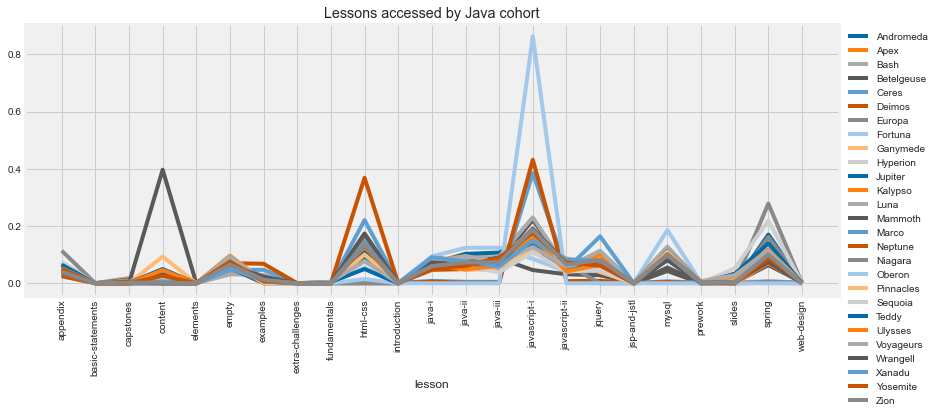

In [908]:
rel_java_df.plot()
plt.xticks(range(0,len(rel_java_df.index)), rel_java_df.index, rotation=90)
ax = plt.subplot(111)
plt.title("Lessons accessed by Java cohort")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

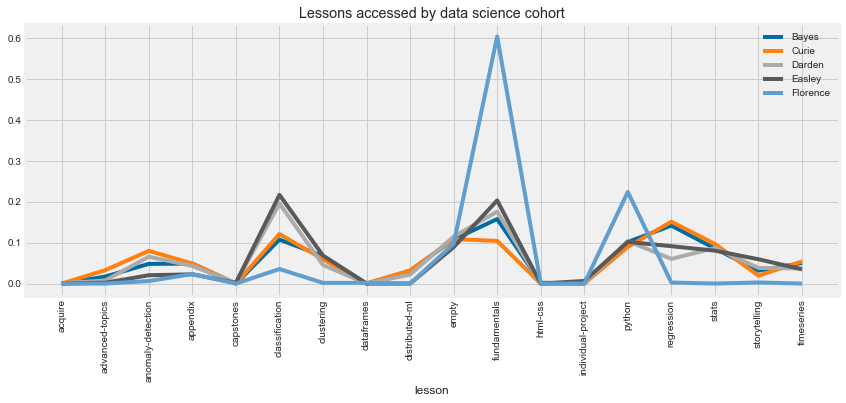

In [815]:
rel_data_df.plot()
plt.xticks(range(0,len(rel_data_df.index)), rel_data_df.index, rotation=90)
plt.title("Lessons accessed by data science cohort")
plt.show()

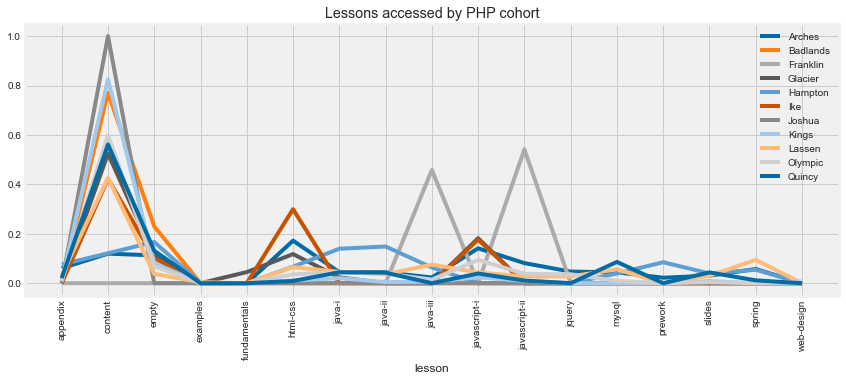

In [816]:
rel_php_df.plot()
plt.xticks(range(0,len(rel_php_df.index)), rel_php_df.index, rotation=90)
plt.title("Lessons accessed by PHP cohort")
plt.show()

In [888]:
#show lessons where cohort is an outlier in activity
for frame in [rel_data_df, rel_java_df, rel_php_df]:
    print("-------")
    for x in range(0, len(frame.index)):
        stdev = 2.5
        row = frame.iloc[x] < frame.iloc[x].mean() - stdev*frame.iloc[x].std()
        if sum(row)>0: print(row[row>0])
        row = frame.iloc[x] > frame.iloc[x].mean() + stdev*frame.iloc[x].std()
        if sum(row)>0: print(row[row>0])

-------
-------
Niagara    True
Name: appendix, dtype: bool
Bash    True
Name: basic-statements, dtype: bool
Bash    True
Name: capstones, dtype: bool
Mammoth    True
Name: content, dtype: bool
Apex    True
Name: elements, dtype: bool
Neptune    True
Name: examples, dtype: bool
Kalypso    True
Name: extra-challenges, dtype: bool
Teddy        True
Voyageurs    True
Name: fundamentals, dtype: bool
Neptune    True
Name: html-css, dtype: bool
Marco    True
Name: introduction, dtype: bool
Oberon    True
Name: java-i, dtype: bool
Oberon    True
Name: javascript-i, dtype: bool
Oberon    True
Name: javascript-ii, dtype: bool
Marco    True
Name: jquery, dtype: bool
Europa    True
Name: jsp-and-jstl, dtype: bool
Voyageurs    True
Name: prework, dtype: bool
Sequoia    True
Name: slides, dtype: bool
Niagara    True
Name: spring, dtype: bool
-------
Lassen    True
Name: examples, dtype: bool
Glacier    True
Name: fundamentals, dtype: bool
Hampton    True
Name: java-i, dtype: bool
Hampton    True
Na

In [885]:
#mean access rate, lessons by program
for frame in [rel_data_df, rel_java_df, rel_php_df]:
    print("-------")
    print(np.mean(frame, axis=1).sort_values(ascending=False))

-------
lesson
fundamentals          0.24938
classification        0.13556
python                0.12446
empty                 0.10356
regression            0.08954
stats                 0.07014
clustering            0.04852
anomaly-detection     0.04414
appendix              0.03734
timeseries            0.03526
storytelling          0.03030
distributed-ml        0.01708
advanced-topics       0.01194
individual-project    0.00128
capstones             0.00064
html-css              0.00040
dataframes            0.00036
acquire               0.00012
dtype: float64
-------
lesson
javascript-i        0.199344
html-css            0.118715
spring              0.096215
mysql               0.090619
jquery              0.070281
java-iii            0.069274
java-ii             0.068874
empty               0.065274
java-i              0.060619
appendix            0.052833
javascript-ii       0.051559
content             0.024989
examples            0.015241
slides              0.008352
capstones

## Post-graduation (same analysis)

In [920]:
#only pings after graduation
df3 = exclude_subs(df, df3, subs)
df3 = df3[df3.index > pd.to_datetime(df3.end_date)]
df3 = df3[df3.name!='Staff-Java'] #remove staff, questions are about students

#now drop rows if path isn't 3+ characters
df3 = df3[df3.path.str.len()>3]

In [921]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84804 entries, 2018-01-26 10:59:06 to 2021-04-21 16:30:30
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   path                84804 non-null  object 
 1   user_id             84804 non-null  int64  
 2   ip                  84804 non-null  object 
 3   name                84804 non-null  object 
 4   start_date          84804 non-null  object 
 5   end_date            84804 non-null  object 
 6   cohort_path_counts  84804 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 5.2+ MB


In [927]:
#make a dataframe with all lessons by cohort
df3['path-cohort'] = df3['path'] + ";" + df3['name']
lessons_df = df3.groupby('path-cohort').count().sort_values(by='cohort_path_counts', ascending=False)
lessons_df = lessons_df.cohort_path_counts[lessons_df.cohort_path_counts > 9]
lessons_df = pd.DataFrame(lessons_df)
lessons_df[['lesson', 'cohort']] = list(lessons_df.index.str.split(';', 1, expand=True))
lessons_df = lessons_df.reset_index(drop=True)

lessons_pivot = lessons_df.pivot(index='lesson', columns='cohort', values='cohort_path_counts').fillna(0)
lessons_pivot.to_csv("project/lessons_counts.csv")
lessons_pivot.head()

cohort,Andromeda-Java,Apex-Java,Arches-PHP,Badlands-PHP,Bash-Java,Bayes-Data,Betelgeuse-Java,Ceres-Java,Curie-Data,Darden-Data,...,Pinnacles-Java,Quincy-PHP,Sequoia-Java,Teddy-Java,Ulysses-Java,Voyageurs-Java,Wrangell-Java,Xanadu-Java,Yosemite-Java,Zion-Java
lesson,,,,,,,,,,,,,,,,,,,,,
advanced-topics,0.0,0.0,0.0,0.0,0.0,76.0,0.0,0.0,41.0,68.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anomaly-detection,0.0,0.0,0.0,0.0,0.0,183.0,0.0,0.0,199.0,246.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
appendix,214.0,262.0,76.0,0.0,165.0,95.0,100.0,230.0,190.0,237.0,...,107.0,23.0,243.0,317.0,232.0,201.0,117.0,186.0,63.0,200.0
capstones,0.0,60.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,28.0
classification,0.0,0.0,0.0,0.0,0.0,494.0,0.0,0.0,445.0,376.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [928]:
java_df, data_df, php_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

#divide columns by program
for col in lessons_pivot.columns:
    p = col[-4:]
    if p == 'Java':
        java_df[col[:-5]] = lessons_pivot[col]
    elif p == 'Data':
        data_df[col[:-5]] = lessons_pivot[col]
    else:
        php_df[col[:-4]] = lessons_pivot[col]

#drop unused rows
java_df=java_df.loc[(java_df!=0).any(axis=1)].astype(int)
data_df=data_df.loc[(data_df!=0).any(axis=1)].astype(int)
php_df=php_df.loc[(php_df!=0).any(axis=1)].astype(int)

#convert values to column-wise percentages
rel_java_df = round(java_df/java_df.sum(),4)
rel_data_df = round(data_df/data_df.sum(),4)
rel_php_df = round(php_df/php_df.sum(),4)

In [929]:
#most accessed lessons
for frame in [java_df,data_df,php_df]:
    print("------")
    for ix, col in enumerate(frame.columns):
        top=frame[col][frame[col]==frame.max()[ix]]
        print(col, top.values[0], top.index[0])

------
Andromeda 877 spring
Apex 702 java-ii
Bash 332 spring
Betelgeuse 555 javascript-i
Ceres 763 javascript-i
Deimos 1406 javascript-i
Europa 323 javascript-i
Fortuna 464 spring
Ganymede 594 javascript-i
Hyperion 252 spring
Jupiter 87 spring
Mammoth 241 content
Niagara 76 spring
Pinnacles 192 javascript-i
Sequoia 682 spring
Teddy 870 spring
Ulysses 587 spring
Voyageurs 539 spring
Wrangell 250 spring
Xanadu 400 spring
Yosemite 172 spring
Zion 673 html-css
------
Bayes 606 fundamentals
Curie 569 empty
Darden 386 empty
------
Arches 216 html-css
Badlands 57 content
Franklin 13 javascript-ii
Glacier 245 content
Hampton 55 empty
Ike 79 content
Joshua 258 content
Kings 2223 content
Lassen 1110 content
Olympic 1359 content
Quincy 632 content


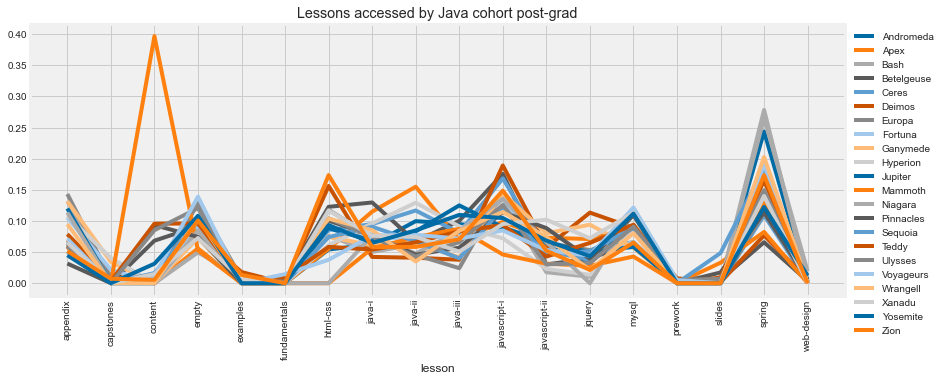

In [933]:
rel_java_df.plot()
plt.xticks(range(0,len(rel_java_df.index)), rel_java_df.index, rotation=90)
ax = plt.subplot(111)
plt.title("Lessons accessed by Java cohort post-grad")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

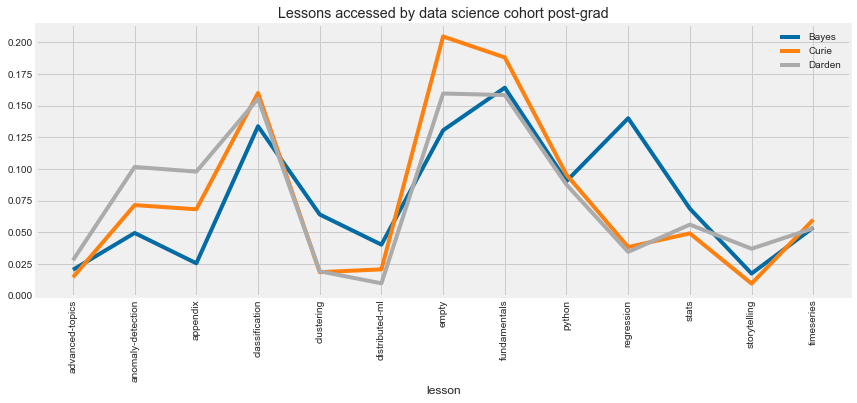

In [934]:
rel_data_df.plot()
plt.xticks(range(0,len(rel_data_df.index)), rel_data_df.index, rotation=90)
plt.title("Lessons accessed by data science cohort post-grad")
plt.show()

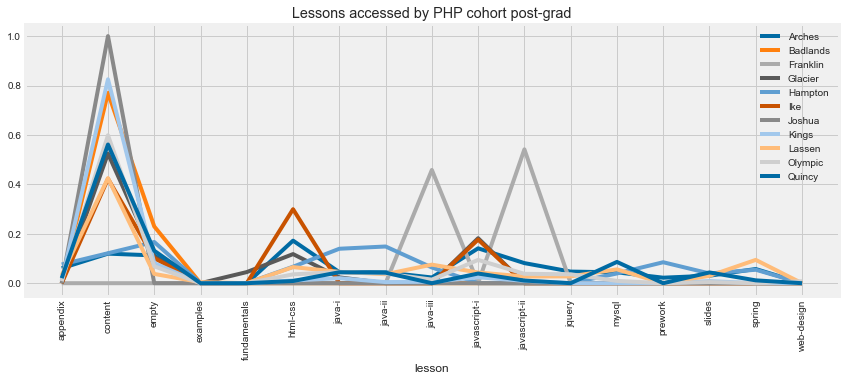

In [935]:
rel_php_df.plot()
plt.xticks(range(0,len(rel_php_df.index)), rel_php_df.index, rotation=90)
plt.title("Lessons accessed by PHP cohort post-grad")
plt.show()